# Barclays Premier League Fantasy Football Data Analysis

## Introduction

I've been really into BPL Fantasy Football this season and have been building a fantasy team since the start of the season last year. 

I'm not very good at picking the right squad based on my instincts, so my basic goal is to use the data from the present and past weeks to determine the best picks for the upcoming week.

## How Fantasy Football Works

I play Fantasy Football off the <a href='http://fantasy.premierleague.com'> official BPL Fantasy site</a>. For the uninitiated, Fantasy Football is an online game where users pick a squad of 15 real-life football players from a league. In this case, I'm playing the BPL, which is the English top division. Points are scored and collated depending on a player's actions in the actual game. The aim of the game is to amass the highest number of points each game week. The rules are <a href='http://fantasy.premierleague.com/rules/'> here</a>. Friends tend to form mini-competitions to see who's better at picking the best squad week after week. At the end of the season, the winner of their league with the higest points gets the honour of having the best fantasy football instincts (although there's usually money involved in mini-leagues amongst friends). There's a budget allocated to each user so you can't always choose the best player. Players get transferred in and out of teams weekly, so there's an entire transfer market 

## Fantasy Football Data

Data is available from an API from the official site on players' basic information, team information, fixture information and performance stats. Each player's performance is aggregated every gameweek to give an overall view of the players' performance. There are nested data sets on each player's weekly performance history, as well as performance in past seasons.    

There are 549 players in the fantasy football database. I'll import some basic data on them for a start. 

In [213]:
import requests as rq

In [261]:
## Taking a look at one player's data 

r25 = rq.get('http://fantasy.premierleague.com/web/api/elements/3')
d25 = r25.json()

## The data fields available for each player. 

print d25.keys()
print len(d25.keys())

[u'transfers_out', u'yellow_cards', u'code', u'event_total', u'goals_conceded', u'photo', u'red_cards', u'saves', u'ep_this', u'value_form', u'next_fixture', u'team_id', u'goals_scored', u'loans_in', u'web_name', u'value_season', u'team_name', u'cost_change_start_fall', u'team_code', u'fixtures', u'special', u'first_name', u'transfers_out_event', u'chance_of_playing_next_round', u'cost_change_start', u'cost_change_event_fall', u'event_explain', u'type_name', u'bps', u'id', u'bonus', u'season_history', u'total_points', u'penalties_missed', u'status', u'form', u'own_goals', u'loaned_in', u'current_fixture', u'now_cost', u'fixture_history', u'clean_sheets', u'assists', u'selected_by_percent', u'transfers_in', u'loans_out', u'news', u'ea_index', u'penalties_saved', u'dreamteam_count', u'in_dreamteam', u'points_per_game', u'minutes', u'loaned_out', u'transfers_in_event', u'selected_by', u'element_type', u'ep_next', u'team', u'chance_of_playing_this_round', u'event_points', u'second_name', u

In [283]:
import re

### Diving deeper into Player Data 

There are a total of 63 data attributes for any single player. Each player has a unique player id, and data is updated once every <i>gameweek</i>. That is to say, a full round of fixtures played amongst 20 teams. [Note: Fixtures sometimes get postponed from one gameweek to another, so that might be a complication for the data set.] 

In essence, the gameweek view reflects the player's (a) cumulative performance up to that gameweek and (b) the player's performance in that particular gameweek. 

Above that, there are some <b>nested</b> attributes that give us a whole lot more information. For instance, for each player, the attribute 'fixture_history' returns the players performance down to the individual fixtures of the current season played up to the current gameweek. 'season_history' returns the players' cumulative performance over the past few seasons (if they are available). 

This presents a whole different order of magnitude of information, so I'll be focusing on gameweek level data for a start. 

The Fantasy League API doesn't really have a guide, so I'm going to give a brief overview of the variables I'll be using for a start:

- <b>Personal Attributes</b>
    - Player ID - Unique Identifier
    - First Name, Last name
    - Position, ie. Goalkeeper, Midfielder
- <b>Team Attributes</b>
    - Team name, Team ID
- <b>Real Life Performance Attributes</b> (measured up to current gameweek)
    - Total Goals scored
    - Assists
    - Goals Conceded
    - Total minutes played
- <b>Fantasy Performance Attributes</b> 
    - Total points scored
    - Points per game
    - Total Bonus points
    - Number of points scored in the most recent gameweek
    - Number of Bonus points scored in the most recent gameweek

[<i>These characterise the fantasy points, measured up to current gameweek, that each player has scored according to the fantasy system, and not in "real life". Bonus points are tallied in a separate system, where more "minor actions" in a game, such as a shot on target, a tackle or a clearance can be tallied. These do not directly contribute towards fantasy points.</i>]
 
- <b> Transfer Market Attributes</b>
    - Total Transfers In
    - Total Transfers Out
- <b> Injury Attributes </b>
    - % Chance of playing in this round
    - % Chance of playing in the next round

With that, I'm going to extract the fantasy points as the outcome variable and 21 features for 549 players. 

In [414]:
required_fields=['id','first_name','second_name','team_name','team_id','type_name','event_points','assists','goals_scored','goals_conceded','now_cost','bonus','bps','dreamteam_count','chance_of_playing_next_round','chance_of_playing_this_round','minutes','form','points_per_game','next_fixture','total_points']
print (len(required_fields))

21


In [415]:
data=[]
t_form=[]
for i in range(1,551):
    r = rq.get('http://fantasy.premierleague.com/web/api/elements/%d' %(i))
    d = r.json()
    p_data = [d[required_fields[j]] for j in range(len(required_fields))]
    p_hist = d['fixture_history']['all']
    bonus_form = sum([p_hist[j][16] for j in range((len(p_hist)-5),(len(p_hist)-2))])
    fantasy_form = sum([p_hist[j][19] for j in range((len(p_hist)-5),(len(p_hist)-2))])
    for j in range((len(p_hist)-5),(len(p_hist)-2)):
        g= re.match("(.*)(...) ([0-9]+)?-?([0-9]+)",p_hist[j][2])
        if g.groups()[2]==g.groups()[3]:
            result=1
        elif g.groups()[2]>g.groups()[3]:
            result = 3
        elif g.group()[2]<g.groups()[3]:
            result =0
        t_form.append(result)
    own_team_form=sum(t_form)
    t_form=[]
    home = re.match("(.*)(...) ([0-9]+)?-?([0-9]+)",p_hist[len(p_hist)-1][2]).groups()[1] == '(H)'
    p_data.extend([bonus_form,fantasy_form,own_team_form,home])
    data.append(p_data)

In [416]:
required_fields.extend(['bonus_form','fantasy_form','own_team_form','home'])
required_fields

['id',
 'first_name',
 'second_name',
 'team_name',
 'team_id',
 'type_name',
 'event_points',
 'assists',
 'goals_scored',
 'goals_conceded',
 'now_cost',
 'bonus',
 'bps',
 'dreamteam_count',
 'chance_of_playing_next_round',
 'chance_of_playing_this_round',
 'minutes',
 'form',
 'points_per_game',
 'next_fixture',
 'total_points',
 'bonus_form',
 'fantasy_form',
 'own_team_form',
 'home']

In [417]:
# Convert to data frame.. 

import csv 
import pandas as pd
df = pd.DataFrame(data,columns=required_fields)

In [418]:
## I'm going to export the data to a csv so I don't have to keep pinging the API. 

df.to_csv('Fantasy Gameweek 26.csv', encoding='utf')

In [432]:
## Top 10 players in Fantasy Football

df.sort_values(by='total_points',ascending=False).head(10)

,id,first_name,second_name,team_name,team_id,type_name,event_points,assists,goals_scored,goals_conceded,...,chance_of_playing_this_round,minutes,form,points_per_game,next_fixture,total_points,bonus_form,fantasy_form,own_team_form,home
162,163,Riyad,Mahrez,Leicester,7,Midfielder,1,10,14,21,...,100,2016,6.8,7.4,Norwich (H),184,26,13,7,False
169,170,Jamie,Vardy,Leicester,7,Forward,7,5,19,28,...,100,2268,7.3,6.3,Norwich (H),163,104,24,7,False
14,15,Mesut,Özil,Arsenal,1,Midfielder,8,17,4,20,...,100,2079,5.8,6.5,Man Utd (A),156,27,5,3,True
148,149,Romelu,Lukaku,Everton,6,Forward,2,5,16,35,...,100,2241,3.5,5.9,,153,2,5,5,True
441,442,Odion,Ighalo,Watford,18,Forward,2,6,15,28,...,100,2218,4.5,5.8,Bournemouth (H),151,46,16,5,False
349,350,Harry,Kane,Spurs,14,Forward,6,2,16,18,...,NaN,2292,6.5,5.3,Swansea (H),137,115,28,9,False
137,138,Ross,Barkley,Everton,6,Midfielder,2,8,8,34,...,NaN,2272,5.8,5.2,,135,61,20,5,True
2,3,Petr,Cech,Arsenal,1,Goalkeeper,2,0,0,23,...,NaN,2340,5.8,4.8,Man Utd (A),125,81,21,3,True
340,341,Christian,Eriksen,Spurs,14,Midfielder,10,10,5,17,...,100,1869,7.8,5.3,Swansea (H),123,125,33,9,False
496,497,Georginio,Wijnaldum,Newcastle,11,Midfielder,1,4,9,46,...,NaN,2252,2.0,4.7,,123,68,17,9,False


In [420]:
## Just some cleaning to make sure the strings are converted to floating numbers.

df.form = df.form.astype(float)
df.points_per_game = df.points_per_game.astype(float)

In [421]:
## Summary Statistics

df.describe()

,id,team_id,event_points,assists,goals_scored,goals_conceded,now_cost,bonus,bps,dreamteam_count,chance_of_playing_next_round,chance_of_playing_this_round,minutes,form,points_per_game,total_points,bonus_form,fantasy_form,own_team_form,home
count,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,430.000000,428.000000,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,550
mean,275.500000,10.410909,1.180000,1.009091,1.101818,12.978182,50.970909,2.790909,173.821818,0.487273,63.430233,62.441589,885.038182,1.342364,2.151091,36.176364,19.900000,4.220000,6.061818,0.483636
std,158.915596,5.789434,2.346637,1.866664,2.343964,12.257390,12.337064,4.466625,167.652834,1.013040,46.636656,47.492722,797.369163,1.793229,1.557258,35.422763,25.911981,5.932894,2.291943,0.500187
min,1.000000,1.000000,-3.000000,0.000000,0.000000,0.000000,37.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-0.300000,-0.500000,-1.000000,-2.000000,0.000000,3.000000,False
25%,138.250000,5.000000,0.000000,0.000000,0.000000,1.000000,43.000000,0.000000,7.250000,0.000000,0.000000,0.000000,55.500000,0.000000,1.000000,2.000000,0.000000,0.000000,3.000000,0
50%,275.500000,10.000000,0.000000,0.000000,0.000000,11.000000,47.000000,0.000000,126.500000,0.000000,100.000000,100.000000,760.500000,0.500000,2.200000,28.000000,4.000000,1.000000,7.000000,0
75%,412.750000,15.000000,2.000000,1.000000,1.000000,22.000000,54.000000,4.000000,299.750000,1.000000,100.000000,100.000000,1544.000000,2.225000,3.200000,59.000000,37.750000,7.000000,9.000000,1
max,550.000000,20.000000,15.000000,17.000000,19.000000,50.000000,136.000000,32.000000,644.000000,10.000000,100.000000,100.000000,2340.000000,9.800000,7.400000,184.000000,132.000000,33.000000,9.000000,True


In [422]:
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import numpy as np

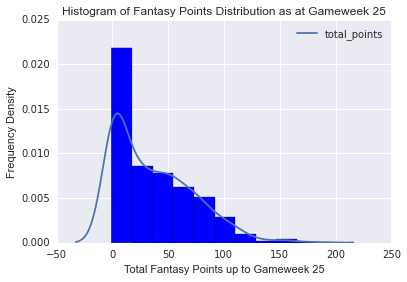

In [423]:
# One response variable here is the amount of fantasy points scored. Let's take a look at the distribution

plt.hist(df.total_points,color='blue',normed=True)
plt.title("Histogram of Fantasy Points Distribution as at Gameweek 26")
plt.ylabel("Frequency Density")
plt.xlabel("Total Fantasy Points up to Gameweek 26")
sns.kdeplot(df.total_points)

Data is highly skewed to the left. About 20% of players score 10 points and below. These are probably guys from the reserve team, long term injuries etc. 

Let's look at how the features correlate with our response variable

In [424]:
df.corr()['total_points']

id                             -0.067488
team_id                        -0.019681
event_points                    0.460971
assists                         0.655133
goals_scored                    0.652215
goals_conceded                  0.755811
now_cost                        0.485286
bonus                           0.840500
bps                             0.938958
dreamteam_count                 0.699658
chance_of_playing_next_round    0.423601
chance_of_playing_this_round    0.430077
minutes                         0.906495
form                            0.736912
points_per_game                 0.820001
total_points                    1.000000
bonus_form                      0.721936
fantasy_form                    0.724479
own_team_form                   0.001099
home                           -0.010066
Name: total_points, dtype: float64

Pretty strong associations all around, likely >0 for most features. Highest correlation between 'bps' variable and fantasy points scored. This is expected because 'bps' is kind of like a captures fantasy point scoring actions and then some.

Going back to the analytical objective of predicting the highest fantasy points scorer, it would be instructive to consider the outcome variable as the number of points scored in the current week.

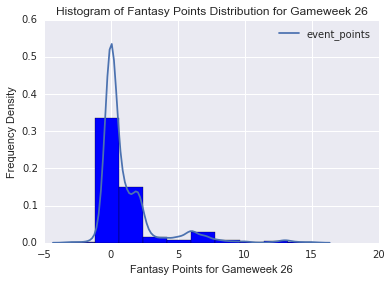

In [425]:
# Let's look at the distribution again..

plt.hist(df.event_points,color='blue',normed=True)
plt.title("Histogram of Fantasy Points Distribution for Gameweek 26")
plt.ylabel("Frequency Density")
plt.xlabel("Fantasy Points for Gameweek 26")
sns.kdeplot(df.event_points)

Expectedly, this is even more skewed because any given team is allowed to play 11 players and field three substitutes, leaving only a maximum of 14 out of a typical squad of 28 that can score points. 

In [426]:
df.corr()['event_points']

id                             -0.002611
team_id                         0.050455
event_points                    1.000000
assists                         0.429594
goals_scored                    0.351329
goals_conceded                  0.312335
now_cost                        0.313132
bonus                           0.419629
bps                             0.414457
dreamteam_count                 0.347681
chance_of_playing_next_round    0.397265
chance_of_playing_this_round    0.376798
minutes                         0.385982
form                            0.625656
points_per_game                 0.441847
total_points                    0.460971
bonus_form                      0.409134
fantasy_form                    0.399853
own_team_form                   0.051776
home                           -0.080510
Name: event_points, dtype: float64

What stands out for me here is that form seems like more highly correlated that the cumulative points, or points per game. This means that the a player's performance in the past few games is likely to be a better predictor of his current performance than his performance in the overall season.

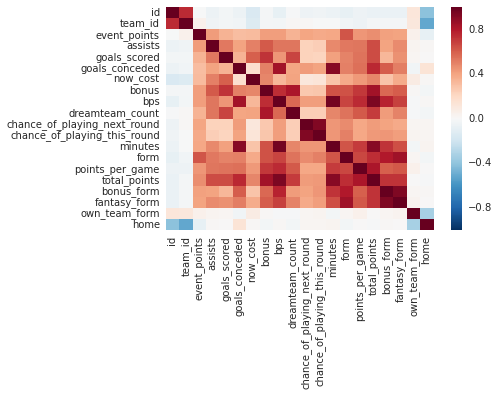

In [427]:
## Just do a heatmap to see if there are any strong intra-feature correlations...

sns.heatmap(df.corr())

This preliminary analysis leads me to the conclusion that I should be digging a bit more into the player's form to uncover more features to predict his next gameweek's performance. 

Given this, I have added more features into the dataset on a player's form. I have three new features on a player's form : (a) fantasy form, the sum of all fantasy points of a player over the past 3 weeks; (b) bonus_form, the sum of all bonus points of a player over the past 3 weeks; and (c) own team form, the amount of points that the player's team has accumulated in the past 3 weeks. 


In [428]:
# Simple Linear Regression 
import statsmodels.formula.api as smf
lm= smf.ols(formula='event_points ~ form + total_points + minutes + bps + bonus + now_cost + fantasy_form + bonus_form + own_team_form + home',data=df)

results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           event_points   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     48.53
Date:                Thu, 18 Feb 2016   Prob (F-statistic):           8.30e-69
Time:                        23:31:11   Log-Likelihood:                -1072.5
No. Observations:                 550   AIC:                             2167.
Df Residuals:                     539   BIC:                             2214.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        -1.0704      0.422     -2.534      0.012        -1.900    -0.241
home[T.True]     -0.2144      0.157     -1.365      0.173        -0.523     0.094
form              1.2349      0.083     14.967      0.000         1.073     1.397
total_points      0.0024      0.011      0.210      0.834        -0.020     0.025
minutes           0.0002      0.000      0.372      0.710        -0.001     0.001
bps              -0.0015      0.002     -0.620      0.535        -0.006     0.003
bonus             0.0259      0.039      0.669      0.504        -0.050     0.102
now_cost          0.0230      0.008      2.999      0.003         0.008     0.038
fantasy_form     -0.2891      0.047     -6.218      0.000        -0.380    -0.198
bonus_form        0.0262      0.011      2.376      0.018         0.005     0.048
own_team_form     0.0300      0.034      0.878      0.381        -0.037     0.097
==============================================================================
Omnibus:                      167.701   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1069.321
Skew:                           1.179   Prob(JB):                    6.31e-233
Kurtosis:                       9.411   Cond. No.                     7.06e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

There is some significance in the new form variables I've created except for the team's form. This is evidence against the hypothesis that a team's form influences a player's individual performance significantly.

### Naive Bayes Classifiers

For Gameweek 26, I'm going to try out NB Classifiers on my data set using some selected features. 

In [452]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

In [455]:
# Create Binary Variable

df['points_scorer'] = df.event_points>5
df['points_scorer'] = df.points_scorer.astype(int)

# Create new feature set and define new binary outcome variable

X = df[['form', 'minutes', 'bps', 'bonus', 'now_cost', 'fantasy_form', 'bonus_form', 'own_team_form','home']]
y = df['points_scorer']
xtrain, xtest, ytrain, ytest = train_test_split(X, y)

In [456]:
# Recycling a function from the lab

def accuracy_report(clf):
    print "Accuracy: %0.2f%%" % (100 * clf.score(xtest, ytest))

    #Print the accuracy on the test and training dataset
    training_accuracy = clf.score(xtrain, ytrain)
    test_accuracy = clf.score(xtest, ytest)

    print "Accuracy on training data: %0.2f" % (training_accuracy)

In [457]:
# Running three different types of classifiers. Multinomial will not be fitted here because it cannot pass non-integer continuous values in the feature set.

clf_bn=BernoulliNB().fit(xtrain,ytrain)
print "Fit Accuracy for Binomial Naive Bayes"
accuracy_report(clf_bn)

clf_gauss = GaussianNB().fit(xtrain, ytrain)
print "Fit Accuracy for Gaussian Naive Bayes"
accuracy_report(clf_gauss)

clf_log=LogisticRegression().fit(xtrain,ytrain)
print "Fit Accuracy for Logistic Regression"
accuracy_report(clf_log)

Fit Accuracy for Binomial Naive Bayes
Accuracy: 77.54%
Accuracy on training data: 0.83
Fit Accuracy for Gaussian Naive Bayes
Accuracy: 86.23%
Accuracy on training data: 0.86
Fit Accuracy for Logistic Regression
Accuracy: 91.30%
Accuracy on training data: 0.94
